### Load Data and basic analysis

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (downloaded https://www.kaggle.com/datasets/carrie1/ecommerce-data?resource=download)
df = pd.read_csv('data/raw-data.csv', encoding='ISO-8859-1')

# Show first 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [94]:
# Initial analysis of data
df.info()       # Data types and null values
print("----------------------------------")
print(f"Qty (rows, columns): {df.shape}")
print("----------------------------------")
df.describe()   # Basic stadistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
----------------------------------
Qty (rows, columns): (541909, 8)
----------------------------------


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [95]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Data clean and transformation

The first thing to do is clean data starting with data type.
- There are some null values -> Eliminate then
- Quantity and UnitPrice with negative values -> Separate then
- Incorrect datatype in "InvoiceDate" and "CustomerID" -> Transform

In [96]:
# Drop rows with missing CustomerID or Description
df.dropna(subset=['CustomerID', 'Description'], inplace=True)
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Convert CustomerID to int
df['CustomerID'] = df['CustomerID'].astype(int)

# Before separate two dataset (sales / returns), add some columns of interest.
# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
# Add Year, Month, Day, Hour columns
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month        
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

# Separate returns/cancellations (Quantity < 0)
dfReturns = df[df['Quantity'] < 0]
df = df[df['Quantity'] > 0]

# Separate rows with UnitPrice <= 0
dfdfReturns = df[df['UnitPrice']< 0]
df = df[df['UnitPrice'] > 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
 9   Year         397884 non-null  int32         
 10  Month        397884 non-null  int32         
 11  Day          397884 non-null  int32         
 12  Hour         397884 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(4)
memory usage: 36.4+ MB


### Keep cleaning...

So far...
- From 541909 rows -> 397884 rows of non-null values
- Data types updated
- Negative values (returns) separated in a new DF so we can focus on sales only

Now lets check distribution to identified outliers.

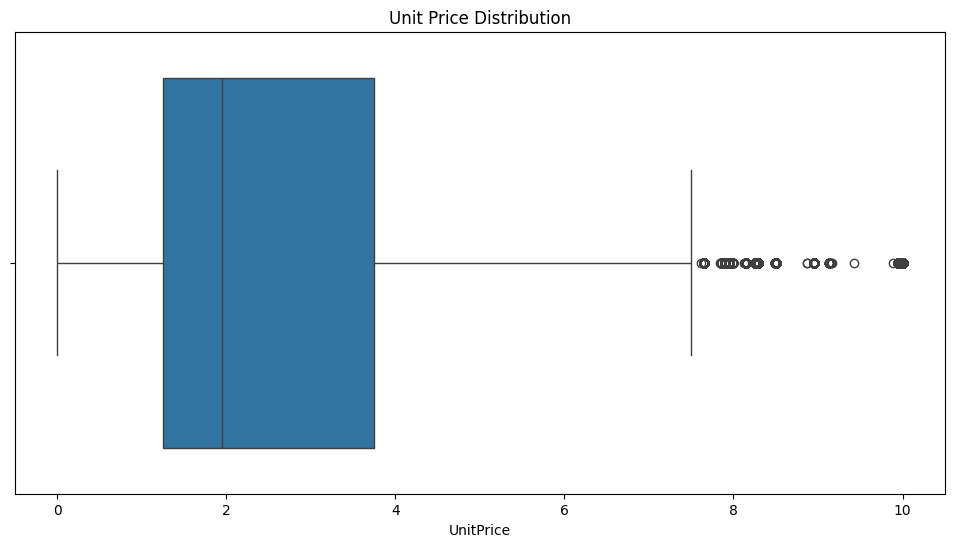

In [100]:
# Check Distribution
plt.figure(figsize=(12,6))
sns.boxplot(x=df['UnitPrice'])
plt.title("Unit Price Distribution")
plt.show()


In [101]:
# Outliers
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

# Upper bound
upper_bound = Q3 + 2.5 * IQR

print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Upper bound (2.5 * IQR): {upper_bound:.2f}")

outliers_count = df[df['UnitPrice'] > upper_bound].shape[0]
print(f"\n {outliers_count}/{df.shape[0]} rows with UnitPrice > {upper_bound*10:.2f} considered outliers.")

# Applying "Capping": replacing the values above the upper limit with the upper limit value
df['UnitPrice'] = np.where(df['UnitPrice'] > upper_bound, upper_bound, df['UnitPrice'])

# Recalcute TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

Q1 (25%): 1.25
Q3 (75%): 3.75
IQR: 2.50
Upper bound (2.5 * IQR): 10.00

 0/397884 rows with UnitPrice > 100.00 considered outliers.


<Figure size 1200x600 with 0 Axes>

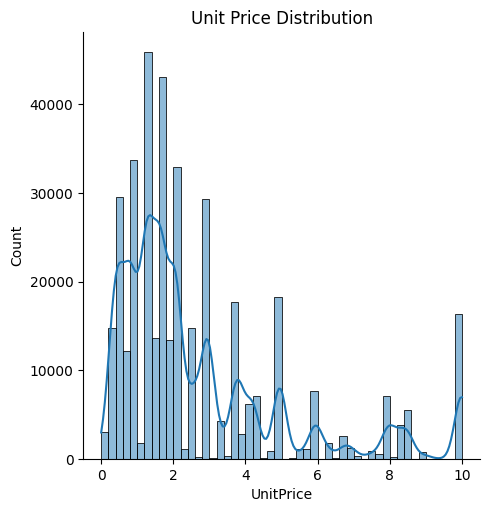

In [102]:
# Check Distribution
plt.figure(figsize=(12,6))
sns.displot(df['UnitPrice'], bins=50, kde=True)
plt.title("Unit Price Distribution")
plt.show()

### SQLite

With clean data, now we are able to load it into a new SQL Database.

In [ ]:
import sqlite3

# 1. Connect to the database (it will create 'e_commerce_db.db' file if not exists)
conn = sqlite3.connect('e_commerce_db.db')

# 2. Load the clean DataFrame into a SQL table called 'Sales'
#    - if_exists='replace'
#    - index=False: do not include DataFrame index as a column
df.to_sql('Sales', conn, if_exists='replace', index=False)


397884